In [11]:
import sys
# Delete all global variables when re-running the notebook.
this = sys.modules[__name__] # type: ignore
for n in dir():
    if n in ['this', 'was_mounted']: continue
    if n[0]!='_': delattr(this, n)


try:
    was_mounted = was_mounted
except:
    was_mounted = False


import os
if  os.getenv("COLAB_RELEASE_TAG"):
  is_running_on_colab = True

else:
  is_running_on_colab = False

if is_running_on_colab:
  packages_to_install = ['pandas==2.1.3','neurokit2', 'wfdb']

  for package in packages_to_install:
    os.system(f'pip install {package}')
  from google.colab import drive, files
  code_directory = './gdrive/MyDrive/TCC/ectopic_beats_detection'
  if not was_mounted:
      drive.mount('/content/gdrive')
  was_mounted = True
  if not os.path.samefile(os.getcwd(),code_directory):
    os.chdir(code_directory)


import gc
import glob
import sys
from datetime import datetime
from multiprocessing import Pool, cpu_count
from os.path import join
from timeit import default_timer as timer

import matplotlib.pyplot as plt
import neurokit2 as nk
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import pyarrow as pa
import torch
import torch.nn as nn
from numba import njit
from torch import flatten
from torch.nn import Conv2d, Linear, LogSoftmax, MaxPool2d, Module, ReLU, LocalResponseNorm
from torchvision import transforms
#from torchshape import tensorshape

from globals import *
from utils import load_df_multi_analysis, load_record, show_image



pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 40)



@njit(cache = True, nogil=True)
def sig_2_pic(signal,height, width,scale):
    samples = signal.shape[0]
    scale_image = (height-10)
    offset = 5
    new_image = np.ones((height, width), dtype=np.uint8)


    x_array = np.arange(0, samples, 1,dtype=np.int32)*(width)//(samples)
    y_array = (scale*scale_image*((signal - signal.min()) / (signal.max() - signal.min()))).astype(np.int32) + offset

    for idx in range(x_array.shape[0] - 1):
        x0, y0, x1, y1 =x_array[idx], y_array[idx], x_array[idx+1], y_array[idx+1]

        ############### Bresenham algorithm ###############
        dx = x1 - x0
        dy = y1 - y0

        xsign = 1 if dx > 0 else -1
        ysign = 1 if dy > 0 else -1

        dx = abs(dx)
        dy = abs(dy)

        if dx > dy:
            xx, xy, yx, yy = xsign, 0, 0, ysign
        else:
            dx, dy = dy, dx
            xx, xy, yx, yy = 0, ysign, xsign, 0

        D = 2*dy - dx
        y = 0

        for x in range(dx + 1):
            xc, yc =  x0 + x*xx + y*yx, y0 + x*xy + y*yy
            new_image[height-1 - yc,xc] = 0
            if D >= 0:
                y += 1
                D -= 2*dx
            D += 2*dy
        ###################################################

    return new_image


old_vars = dir()

df_record_lead_ann = pd.read_parquet(join(dataframes_directory, 'df_record_lead_ann.parquet'))
df_lead_ann_summery =  pd.read_parquet(join(dataframes_directory, 'df_lead_ann_summery.parquet'))
df_ann_summery = pd.read_parquet(join(dataframes_directory, 'df_ann_summery.parquet'))
df_code_description = pd.read_parquet(join(dataframes_directory, 'df_code_description.parquet'))

df_multi_analysis = load_df_multi_analysis(glob.glob(join(dataframes_directory, 'dict_multi_analysis*.pickle')))

In [12]:
list_record_track =  []

for idx, row in df_record_lead_ann.iterrows():
    if row['upper_signal'] == 'MLII':
        signal_track = 0
    elif row['lower_signal'] == 'MLII':
        signal_track = 1
    else:
        continue
    list_record_track.append({'record': row['record'], 'track': signal_track})


In [13]:
derised_anns = LIST_BEATS_2
discard_time = 100
df = pd.DataFrame({'record': pd.Series(dtype=np.uint8),
                   'ecg_beat_indexes': pd.Series(dtype=INDEX_TYPE),
                   'ecg_beat_indexes': pd.Series(dtype=ANN_TYPE)})

dict_records_info = {}
for item in list_record_track:
    record_num = item['record']
    track_num = item['track']

    record, ann = load_record(record_num)

    ecg = record.p_signal[:, 0] #+ record.p_signal[:, 1] # type: ignore

    ecg_beat_indexes = pd.Series(ann.sample, dtype=INDEX_TYPE)
    ecg_beat_anns = pd.Series(ann.symbol, dtype=ANN_TYPE)

     # Mask for time window and derised annotations
    mask_derised_ann = ecg_beat_anns.isin(derised_anns)

    ecg_beat_indexes = ecg_beat_indexes[mask_derised_ann].reset_index(drop=True)
    ecg_beat_anns = ecg_beat_anns[mask_derised_ann].reset_index(drop=True)

    aux_df = pd.DataFrame(
    {
        'record': record_num * np.ones(ecg_beat_indexes.shape[0]-2, dtype=np.uint8),
        'ecg_beat_indexes': ecg_beat_indexes.iloc[1:-1],
        'ecg_beat_anns': ecg_beat_anns.iloc[1:-1]
    }
    )

    df = pd.concat([df, aux_df], ignore_index=True, axis=0)

    dict_records_info[record_num] = {
    'ecg': ecg,
    'ecg_beat_indexes': ecg_beat_indexes,
    'ecg_beat_anns': ecg_beat_anns
    }
k_folds = 5

dict_df_beat_type = {}
for beat_type in derised_anns:
    # Shuffle the dataframe and save it in a dictionary
    aux_df = df[df['ecg_beat_anns'] == beat_type].sample(frac=1).reset_index(drop=True).copy()

    aux_df['fold'] = (aux_df.index/(aux_df.shape[0] +1) * (k_folds)).astype(np.uint8)

    dict_df_beat_type[beat_type] = {
        'df':aux_df,
        'idx': 0
        }


beat_type_quants = df.ecg_beat_anns.value_counts()


for v in dir():
    if v not in old_vars + ['dict_df_beat_type', 'list_record_track', 'dict_records_info', 'old_vars', 'derised_anns', 'beat_type_quants', 'k_folds']:
        #print(v)
        delattr(this, v)
gc.collect()

13435

In [119]:
beat_type_quants

ecg_beat_anns
N    74722
L     8069
R     7250
V     7121
/     3616
A     2544
!      472
E      106
Name: count, dtype: int64[pyarrow]

(-32.75, 687.75, -0.6399999999999999, 0.7899999999999999)

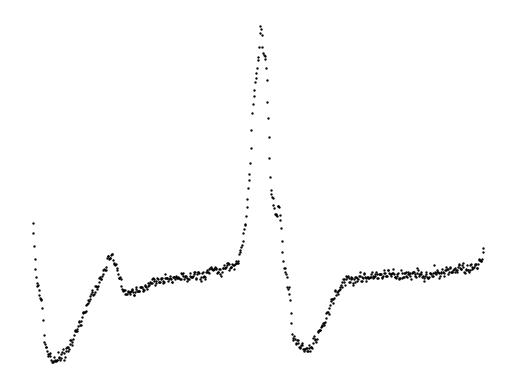

In [41]:
plt.scatter(np.arange(0, ecg.shape[0]), ecg, s=0.5, c='black')

# Remove axis
plt.axis('off')

<Axes: >

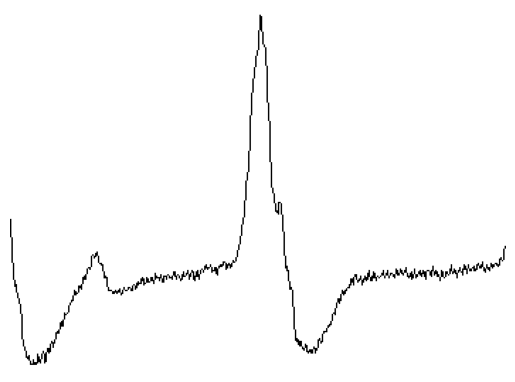

In [46]:
show_image(sig_2_pic(ecg,256,350,1))

In [14]:

# Implement Alexnet architecture in Pytorch
class AlexNet(Module):
    def __init__(self, num_classes=2):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            Conv2d(1, 64, kernel_size=11, stride=4, padding=2),
            nn.BatchNorm2d(64),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=3, stride=2),
            Conv2d(64, 192, kernel_size=5, padding=2),
            nn.BatchNorm2d(192),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=3, stride=2),
            Conv2d(192, 384, kernel_size=3, padding=1),
            nn.BatchNorm2d(384),
            ReLU(inplace=True),
            Conv2d(384, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            ReLU(inplace=True),
            Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            ReLU(inplace=True),
            MaxPool2d(kernel_size=3, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            Linear(256 * 3 * 3, 4096),
            ReLU(inplace=True),
            Linear(4096, 4096),
            ReLU(inplace=True),
            Linear(4096, num_classes),
            #LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.features(x)
        x = flatten(x, 1)
        x = self.classifier(x)
        return x



dict_beat_to_int = {
    'N': 0,
    'L': 1,
    'R': 2,
    'V': 3,
    '/': 4,
    'A': 5,
    '!': 6,
    'E': 7,
}

dict_beat_acronyms = {
    'N': 'NOR',
    'L': 'LBB',
    'R': 'RBB',
    'V': 'PVC',
    '/' : 'PAB',
    'A': 'APC',
    '!' : 'VFW',
    'E': 'VEB',

}


dict_quant_per_batch = {
    'N': 10,
    'L': 5,
    'R': 5,
    'V': 5,
    '/': 3,
    'A': 2,
    '!': 1,
    'E': 1,
 }


quant_per_batch = sum(dict_quant_per_batch.values())

print(f'{quant_per_batch} beats per batch')


height = 128
width = 128

print(f'height: {height}, width: {width}')



def get_signal_from_df(df, idx, rm_left=20, rm_right=20):
    ecg_beat_idx = df.iloc[idx]['ecg_beat_indexes']
    record_num = df.iloc[idx]['record']

    ecg_beat_indexes = dict_records_info[record_num]['ecg_beat_indexes']
    ecg_beat_anns = dict_records_info[record_num]['ecg_beat_anns']
    ecg = dict_records_info[record_num]['ecg']

    ann_beat_index = ecg_beat_indexes[ecg_beat_indexes == ecg_beat_idx].index[0]
    beat_type = ecg_beat_anns[ann_beat_index]

    middle = ecg_beat_indexes[ann_beat_index]
    start = ecg_beat_indexes[ann_beat_index -1]
    end = ecg_beat_indexes[ann_beat_index + 1]

    return ecg[start+rm_left:end-rm_right], beat_type



old_vars = dir()

32 beats per batch
height: 128, width: 128


In [118]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


loss_fn = nn.CrossEntropyLoss()

dict_fold_type_accuracies = {}
dict_fold_accuracies = {}
list_epochs = []
mult_batch = 4

x_np = np.zeros((quant_per_batch *mult_batch , height, width), dtype=np.uint8)
for fold in range(k_folds):
    dict_fold_type_accuracies[fold] = {}
    dict_fold_accuracies[fold] = {}
    print(f'Fold: {fold}')
    np.random.seed(42)
    torch.manual_seed(42)
    model = AlexNet(num_classes=len(dict_beat_to_int)).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(1000):
        beat_idx = 0
        list_beat_type =[]
        for beat_type in derised_anns:
            df = dict_df_beat_type[beat_type]['df']
            df = df[df.fold != fold]
            shape = df.shape[0]
            for i in range(dict_quant_per_batch[beat_type] * mult_batch):  
                idx = dict_df_beat_type[beat_type]['idx']
                if idx >= shape:
                    dict_df_beat_type[beat_type]['idx'] = idx = 0
                else:
                    dict_df_beat_type[beat_type]['idx'] = idx + 1
                
                ecg, beat_type = get_signal_from_df(df, idx, 20+np.random.randint(10), 20+np.random.randint(10))

                #beat_pic = ecg[middle-50:middle+50]
                beat_pic = sig_2_pic(
                    signal = ecg,
                    height = height,
                    width = width,
                    scale = np.random.randint(70,100)/100
                    )
                x_np[beat_idx] = beat_pic
                beat_idx += 1
                list_beat_type.append(dict_beat_to_int[beat_type])

        #[N, C, W, H] = NumSamples x NumChannels x Width x Height 
        x_train = torch.from_numpy(x_np.reshape(quant_per_batch * mult_batch,1, height, width)).float().to(device)
        y_train_labels = torch.tensor(list_beat_type, dtype=torch.long).to(device)
        y_train_onehot = nn.functional.one_hot(y_train_labels, num_classes=len(dict_beat_to_int)).float()
        # Forward pass: Compute predicted y by passing x to the model
        y_pred = model(x_train)
        # Compute loss
        loss =  loss_fn(y_pred, y_train_onehot)

        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


        if epoch % 50 == 0:
            if epoch not in list_epochs:
                list_epochs.append(epoch)
            ########################################### start per fold tests ###########################################
            for metrics_type in ['test']:
                # Resest per fold metrics
                fold_accuracy = 0
                total_fold_tests = 0

                if metrics_type not in dict_fold_type_accuracies[fold]:
                    dict_fold_type_accuracies[fold][metrics_type] = {}

                if metrics_type not in dict_fold_accuracies[fold]:
                    dict_fold_accuracies[fold][metrics_type] = []
                list_beat_type_acc =[]
                for beat_type in derised_anns:
                    if beat_type not in dict_fold_type_accuracies[fold][metrics_type]:
                        dict_fold_type_accuracies[fold][metrics_type][beat_type] = []
                    df = dict_df_beat_type[beat_type]['df']
                    if metrics_type == 'train':
                        df = df[df.fold != fold]
                    elif metrics_type == 'test':
                        df = df[df.fold == fold]
                    shape = min(df.shape[0],1000)
                    beat_type_idx = 0
                    fold_type_accuracy = 0

                    ################################### start per beat type tests ###################################
                    while(True):
                        list_beat_type =[]
                        
                        for beat_pic_idx in range(quant_per_batch * mult_batch):

                            ecg, beat_type = get_signal_from_df(df, beat_type_idx, 20+np.random.randint(10), 20+np.random.randint(10))

                            beat_pic = sig_2_pic(
                                signal = ecg,
                                height = height,
                                width = width,
                                scale = np.random.randint(70,100)/100
                                )
                            x_np[beat_pic_idx] = beat_pic
                            list_beat_type.append(dict_beat_to_int[beat_type])

                            beat_type_idx += 1

                            if beat_type_idx == shape:
                                break

                        x_test = torch.from_numpy(x_np[:beat_pic_idx+1].reshape(beat_pic_idx+1,1, height, width)).float().to(device)
                        y_train_labels = torch.tensor(list_beat_type, dtype=torch.long).to(device)
                        model.eval()
                        with torch.inference_mode():
                            y_pred = model(x_test)

                        y_pred_labels = y_pred.argmax(dim=1)

                        # Compute metrics
                        # True positive
                        tp = (y_pred_labels == y_train_labels).sum().item()
                        # False positive
                        fp = (y_pred_labels != y_train_labels).sum().item()
                        
                        # Because all beats are from the same type, there is no true negative nor false negative
                        # False negative
                        fn = 0
                        # True negative
                        tn = 0

                        # Accuracy for beat type and fold weighted by number of beats (beat_pic_idx)
                        fold_type_accuracy += beat_pic_idx*(100 * (tp + tn) / (tp + tn + fp + fn))/shape
                        
                        if beat_type_idx == shape:
                            dict_fold_type_accuracies[fold][metrics_type][beat_type].append(fold_type_accuracy)
                            list_beat_type_acc.append(fold_type_accuracy)
                            break
                    ################################### end per beat type tests ###################################
                    fold_accuracy += shape * fold_type_accuracy
                    total_fold_tests+=shape
                fold_accuracy = fold_accuracy/total_fold_tests
                dict_fold_accuracies[fold][metrics_type].append(fold_accuracy)
                print(f'\t Epoch: {epoch} {metrics_type} Accuracy: {fold_accuracy:.4f}')
                for beat_type, accuracies in dict_fold_type_accuracies[fold][metrics_type].items():
                    print(f'\t\t{beat_type}: {accuracies[-1]:.4f}')
                ########################################### end per fold tests ###########################################
            
            if min(list_beat_type_acc) > 92:
                # Save model 
                print(f'Saving model at epoch {epoch}')
                torch.save(model.state_dict(), f'./{model._get_name()}_fold_{fold}_epoch_{epoch}.pth')
            
            model.train()


"""
# Save results using pickle
import pickle
with open(f'./{model._get_name()}_dict_fold_accuracies.pickle', 'wb') as handle:
    pickle.dump(dict_fold_accuracies, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(f'./{model._get_name()}_dict_fold_type_accuracies.pickle', 'wb') as handle:
    pickle.dump(dict_fold_type_accuracies, handle, protocol=pickle.HIGHEST_PROTOCOL)"""

Fold: 0
	 Epoch: 0 test Accuracy: 18.5421
		N: 99.2000
		/: 0.0000
		L: 0.0000
		R: 0.0000
		A: 0.0000
		V: 0.0000
		!: 0.0000
		E: 0.0000
	 Epoch: 50 test Accuracy: 20.0996
		N: 88.7837
		/: 0.4111
		L: 5.0591
		R: 3.7700
		A: 7.0171
		V: 6.0511
		!: 0.0000
		E: 0.0000
	 Epoch: 100 test Accuracy: 66.9420
		N: 49.1030
		/: 93.5548
		L: 77.2770
		R: 36.1095
		A: 52.0439
		V: 93.2487
		!: 76.0332
		E: 43.3884
	 Epoch: 150 test Accuracy: 85.2733
		N: 69.7373
		/: 96.8421
		L: 89.6764
		R: 83.0293
		A: 83.4261
		V: 91.2641
		!: 85.4072
		E: 82.4380
	 Epoch: 200 test Accuracy: 85.0886
		N: 79.3602
		/: 96.8421
		L: 80.7487
		R: 93.6447
		A: 77.9681
		V: 82.4360
		!: 78.1163
		E: 82.4380
	 Epoch: 250 test Accuracy: 89.4263
		N: 94.2403
		/: 95.7458
		L: 95.7275
		R: 80.7480
		A: 68.0272
		V: 93.1493
		!: 92.6981
		E: 82.4380
	 Epoch: 300 test Accuracy: 92.8379
		N: 88.5865
		/: 98.3490
		L: 95.8273
		R: 95.9263
		A: 82.4512
		V: 92.2570
		!: 94.7812
		E: 86.7769
	 Epoch: 350 test Accuracy: 8

"\n# Save results using pickle\nimport pickle\nwith open(f'./{model._get_name()}_dict_fold_accuracies.pickle', 'wb') as handle:\n    pickle.dump(dict_fold_accuracies, handle, protocol=pickle.HIGHEST_PROTOCOL)\n\nwith open(f'./{model._get_name()}_dict_fold_type_accuracies.pickle', 'wb') as handle:\n    pickle.dump(dict_fold_type_accuracies, handle, protocol=pickle.HIGHEST_PROTOCOL)"

In [117]:
list_beat_type_acc

[95.45454545454545]

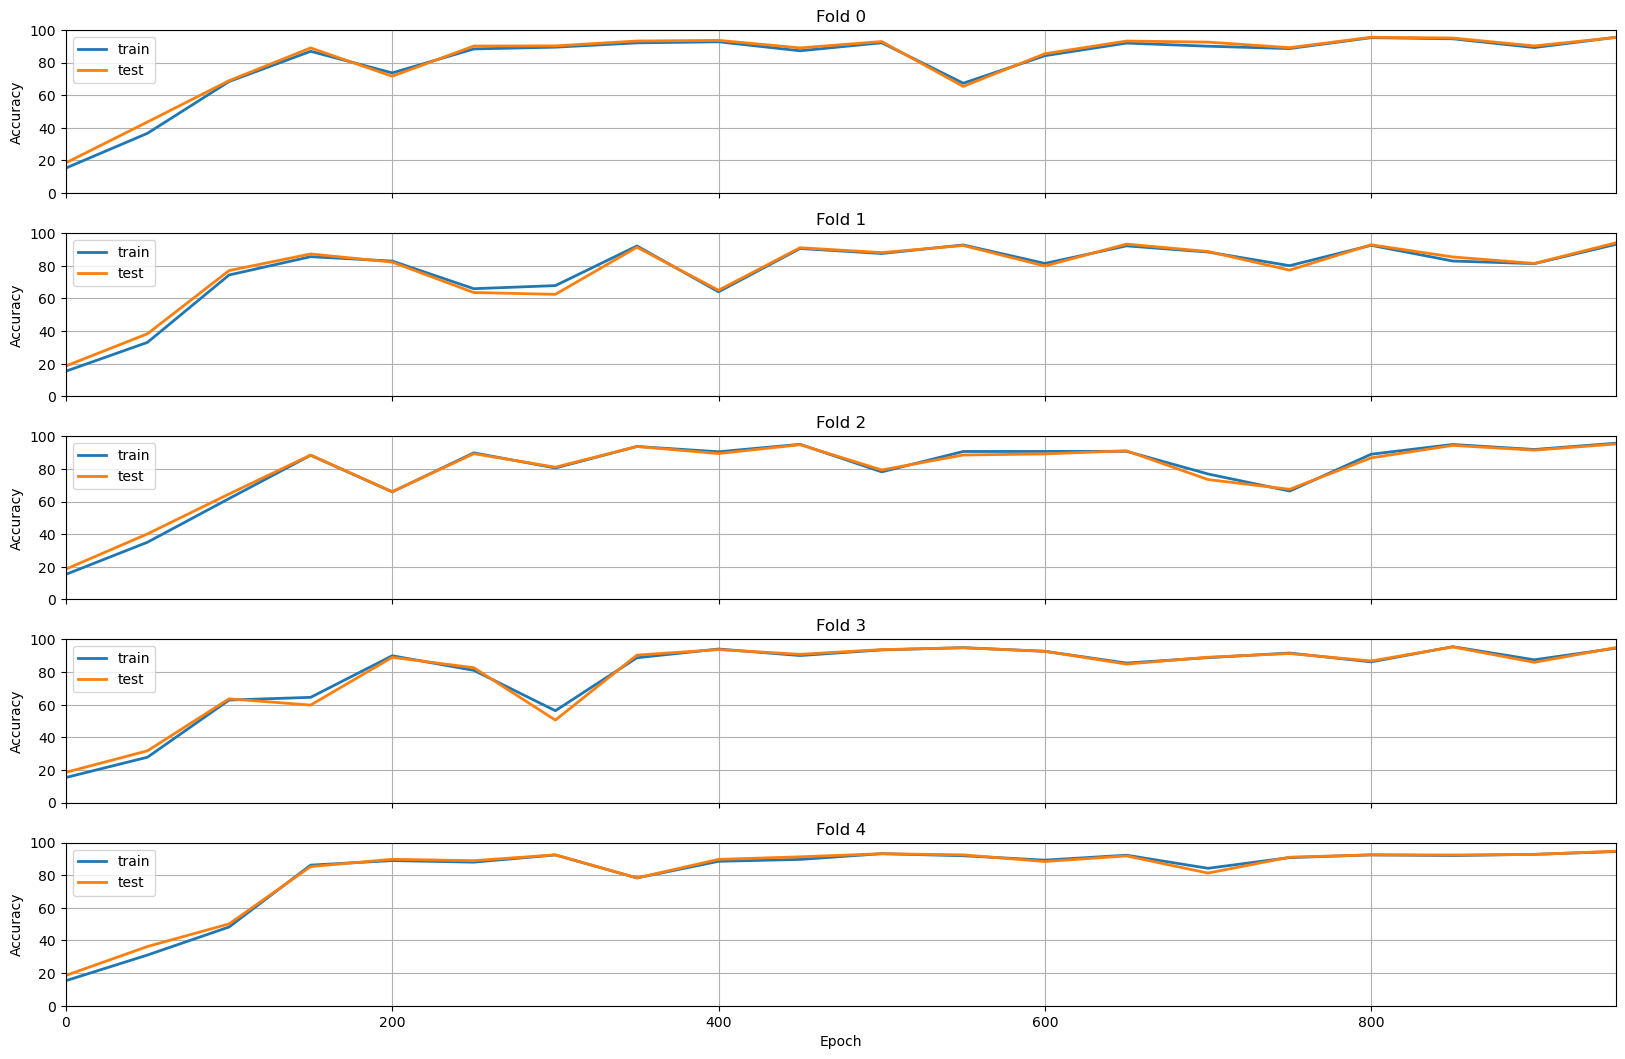

In [60]:
from mpl_toolkits.axes_grid1 import ImageGrid


fig = plt.figure(figsize=(20., 30.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(5, 1),  # creates 2x2 grid of axes
                 axes_pad=0.4,  # pad between axes in inch.
                 )


for fold in range(k_folds):
    ax = grid[fold]
    ax.grid()
    ax.legend()
    for metrics_type in ['train', 'test']:
        ax.plot(list_epochs, dict_fold_accuracies[fold][metrics_type], label=f'{metrics_type}',linewidth=2.0)
        ax.set_title(f'Fold {fold}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy')
        ax.set_ylim([0, 100])
        ax.set_xlim([0, max(list_epochs)])


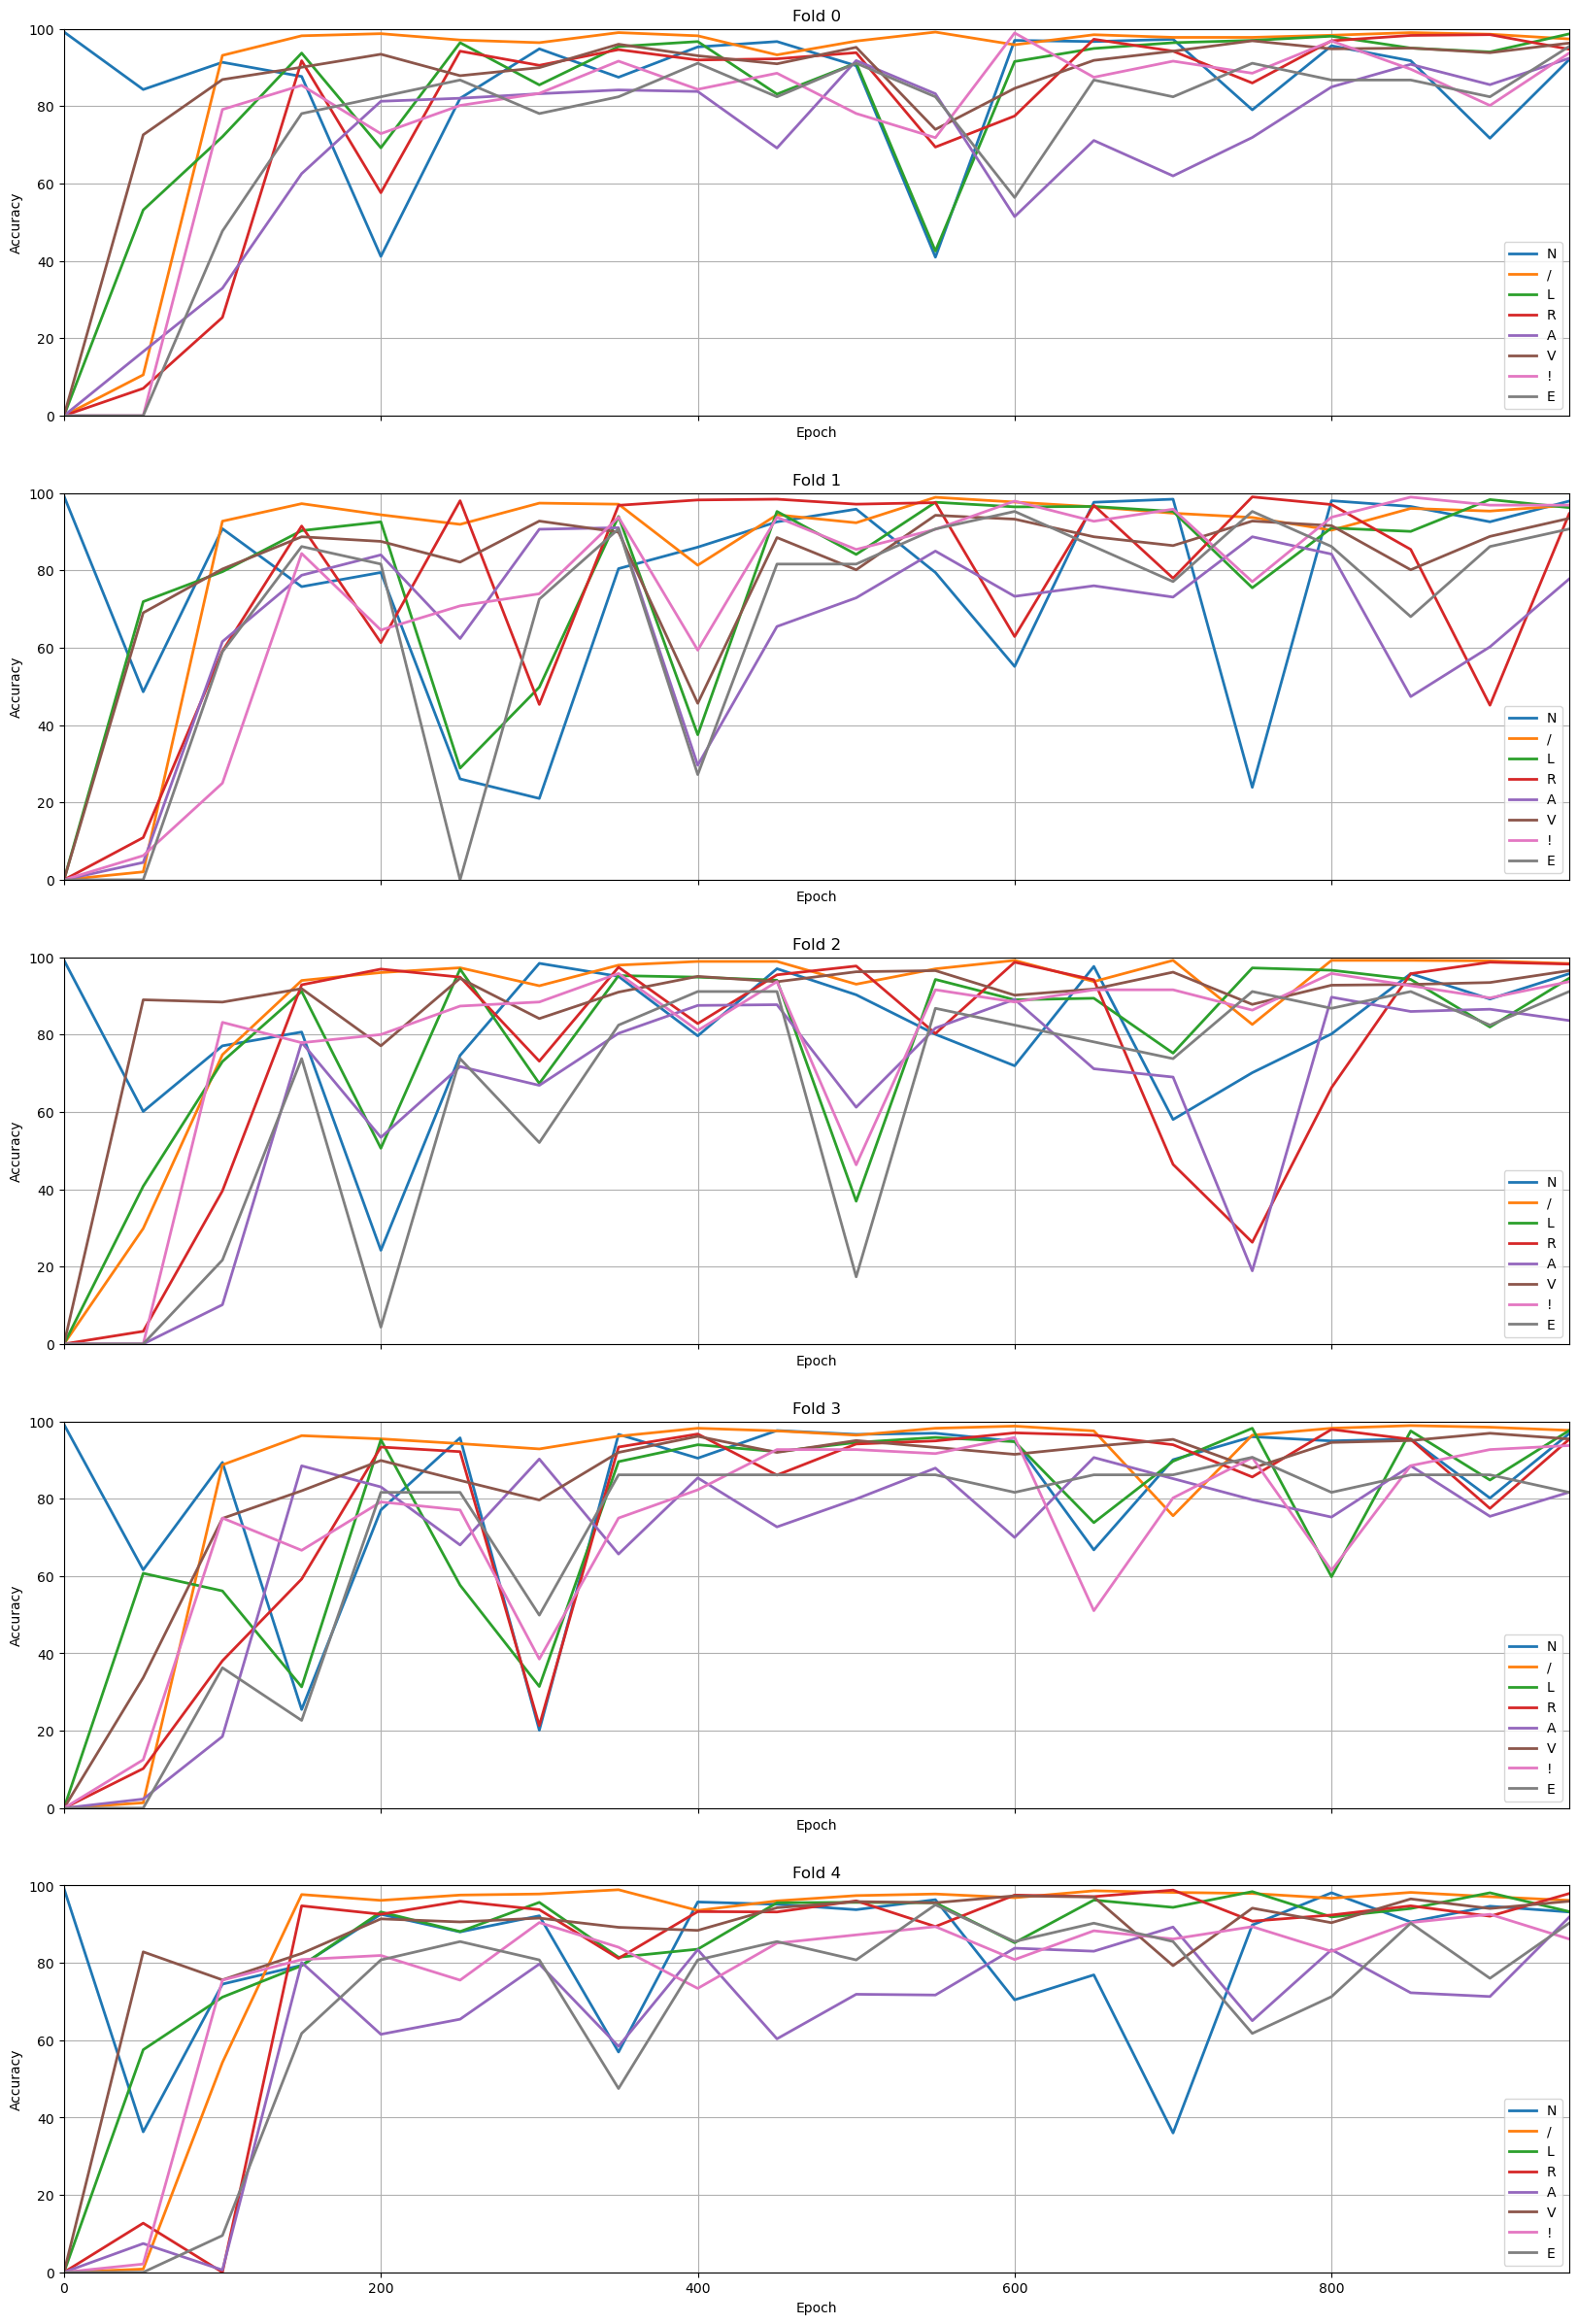

In [80]:
fig, axes = plt.subplots(nrows=5, sharex=True, figsize=(20., 30.))



for fold in range(k_folds):
    ax = axes[fold]
    ax.grid()
    
    for metrics_type in ['test']:#['train', 'test']:
        for beat_type, accuracies in dict_fold_type_accuracies[fold][metrics_type].items():
            ax.plot(list_epochs, accuracies, label=f'{beat_type}',linewidth=2.0)
        #ax.set_ylim([90, 100])
        ax.set_xlim([0, max(list_epochs)])
        ax.legend()
        ax.set_title(f'Fold {fold}')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Accuracy')
        ax.set_ylim([0, 100])
        ax.set_xlim([0, max(list_epochs)])

In [65]:
# Make 5x1 plot grid
fig = plt.figure(figsize=(20., 30.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(k_folds, 1),  # creates 2x2 grid of axes
                 axes_pad=0.4,  # pad between axes in inch.
                 )

[99.2,
 83.5263221153846,
 91.56286057692307,
 88.28828125000001,
 39.680829326923075,
 80.74873798076922,
 94.83509615384617,
 85.70877403846153,
 96.42223557692307,
 97.81093750000001,
 90.27157451923075,
 38.88743990384615,
 97.11730769230769,
 97.31520432692307,
 97.21634615384616,
 79.06310096153845,
 96.22415865384615,
 90.56941105769232,
 68.3490985576923,
 94.1412860576923]

In [111]:
dict_best_epoch = {}


for fold in range(k_folds):
    dict_best_epoch[fold] = {'epoch': 0, 'worse_result': 0}
    for metrics_type in ['test']:#['train', 'test']:
        for epoch_idx in range(len(list_epochs)):
            aux_list = []
            for beat_type, accuracies in dict_fold_type_accuracies[fold][metrics_type].items():
                if beat_type != 'N':
                    continue
                aux_list.append(accuracies[epoch_idx])
            worse_result = min(aux_list)
            if worse_result > dict_best_epoch[fold]['worse_result']:
                dict_best_epoch[fold]['epoch'] = list_epochs[epoch_idx]
                dict_best_epoch[fold]['worse_result'] = worse_result

In [112]:
dict_best_epoch

{0: {'epoch': 0, 'worse_result': 99.2},
 1: {'epoch': 0, 'worse_result': 99.2},
 2: {'epoch': 0, 'worse_result': 99.2},
 3: {'epoch': 0, 'worse_result': 99.2},
 4: {'epoch': 0, 'worse_result': 99.2}}

'E'

In [109]:
for beat_type, accuracies in dict_fold_type_accuracies[0][metrics_type].items():
    print(f'{beat_type}: {accuracies[-1]:.4f}')

N: 92.0577
/: 97.3897
L: 98.7039
R: 94.7361
A: 92.3920
V: 96.3234
!: 93.7396
E: 95.4545
